In [291]:
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt

plt.style.use("seaborn")

In [292]:
%config InlineBackend.figure_format = 'retina' # high resolution figures

In [293]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)

plt.rcParams['savefig.dpi'] = 200
plt.rcParams['axes.labelsize'] = 14

#plt.rcParams.keys()

# 🛠️ Prepare data

In [294]:
data_source = "https://raw.githubusercontent.com/SlavaMelanko/SlavaMelanko/main/blog/data-visualization/debt-22.csv"
debt = pd.read_csv(data_source, sep=";", index_col=0)

In [295]:
debt.drop(columns=["Id"], inplace=True)
debt.rename(columns={"Name": "name", "Debt": "debt"}, inplace=True)

In [296]:
sections = 3
floors = 10 # in each section
apts_per_floor = 8
apts_per_section = apts_per_floor * floors
total_apts = apts_per_section * sections

# add the section and floor columns
for apt_num in debt.index.values:
  section = (apt_num - 1) // apts_per_section # 1st section is actally 0
  floor = ((apt_num - (section * apts_per_section) - 1) // apts_per_floor) + 1
  debt.loc[apt_num, ["section", "floor"]] = [section + 1, floor]

In [297]:
debt["section"] = debt["section"].astype(int)
debt["floor"] = debt["floor"].astype(int)
debt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184 entries, 1 to 239
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   name     184 non-null    object
 1   debt     184 non-null    int64 
 2   section  184 non-null    int64 
 3   floor    184 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 11.3+ KB


In [298]:
debt

,name,debt,section,floor
#,,,,
1,Гулякін Ю.В.,2432,1,1
2,Кутлубаєв Г.В.,2370,1,1
4,Ломанова В.О.,3054,1,1
5,Нелуп Д.К.,297,1,1
8,Шамрай А.О.,5529,1,1
...,...,...,...,...
232,Поліщук І.Б.,1102,3,9
233,Овсеп'ян К.А.,6413,3,10
234,Примак О.В.,4583,3,10


# 📈 Data visualization

In [299]:
total_debt = debt["debt"].sum()
print(f"Total debt is ₴{total_debt:0,}")

Total debt is ₴516,299


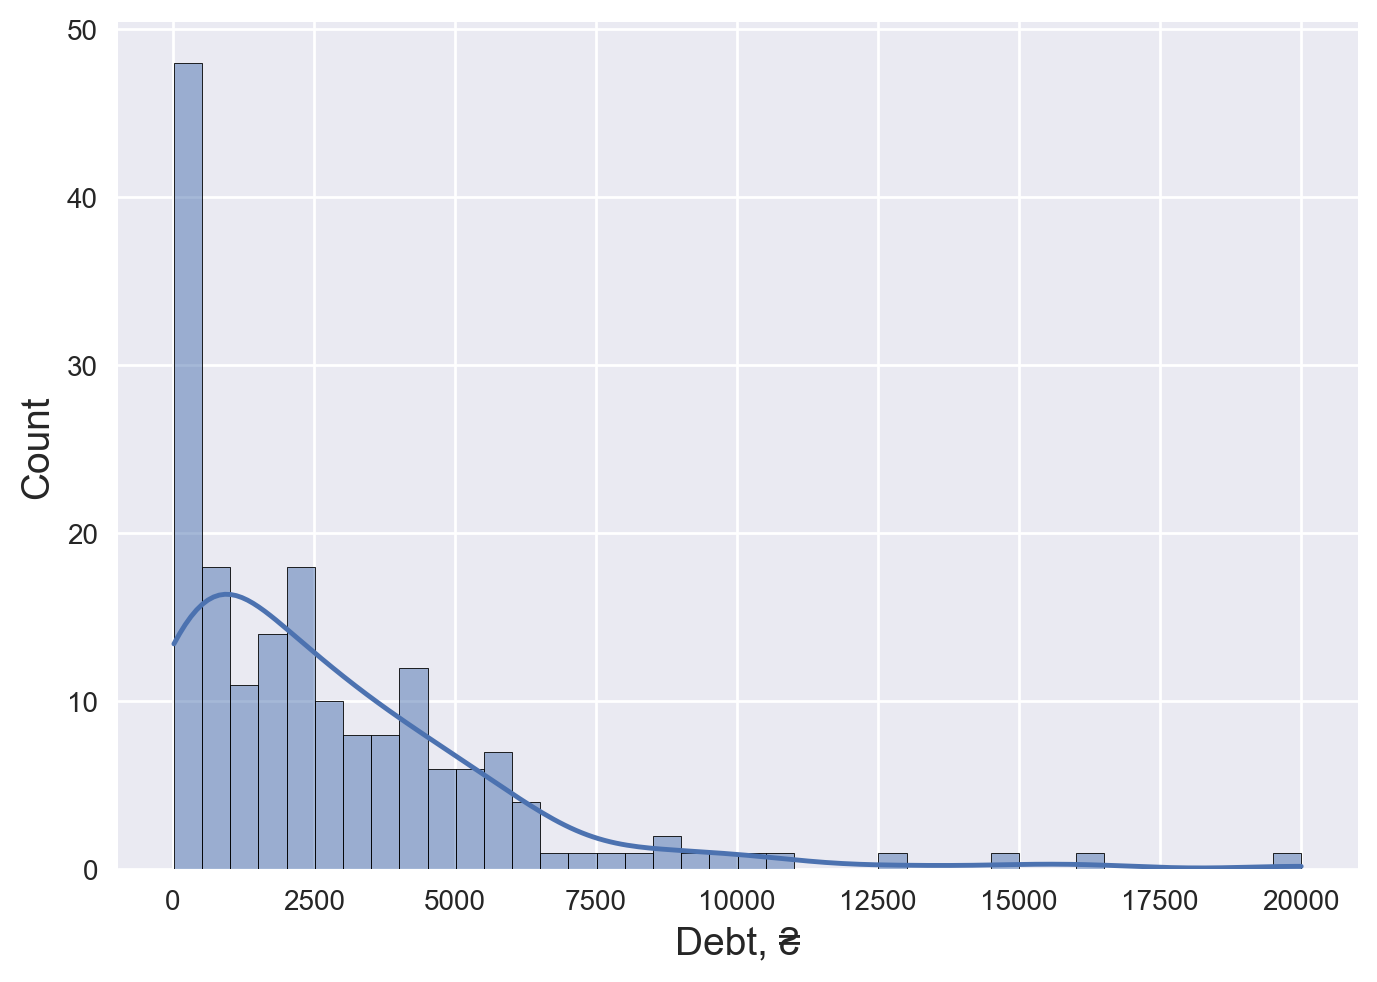

In [300]:
sns.histplot(data=debt, x="debt", bins=40, kde=True)
plt.xlabel("Debt, ₴")
plt.savefig("debt_hist.png")

<AxesSubplot:xlabel='debt', ylabel='Count'>

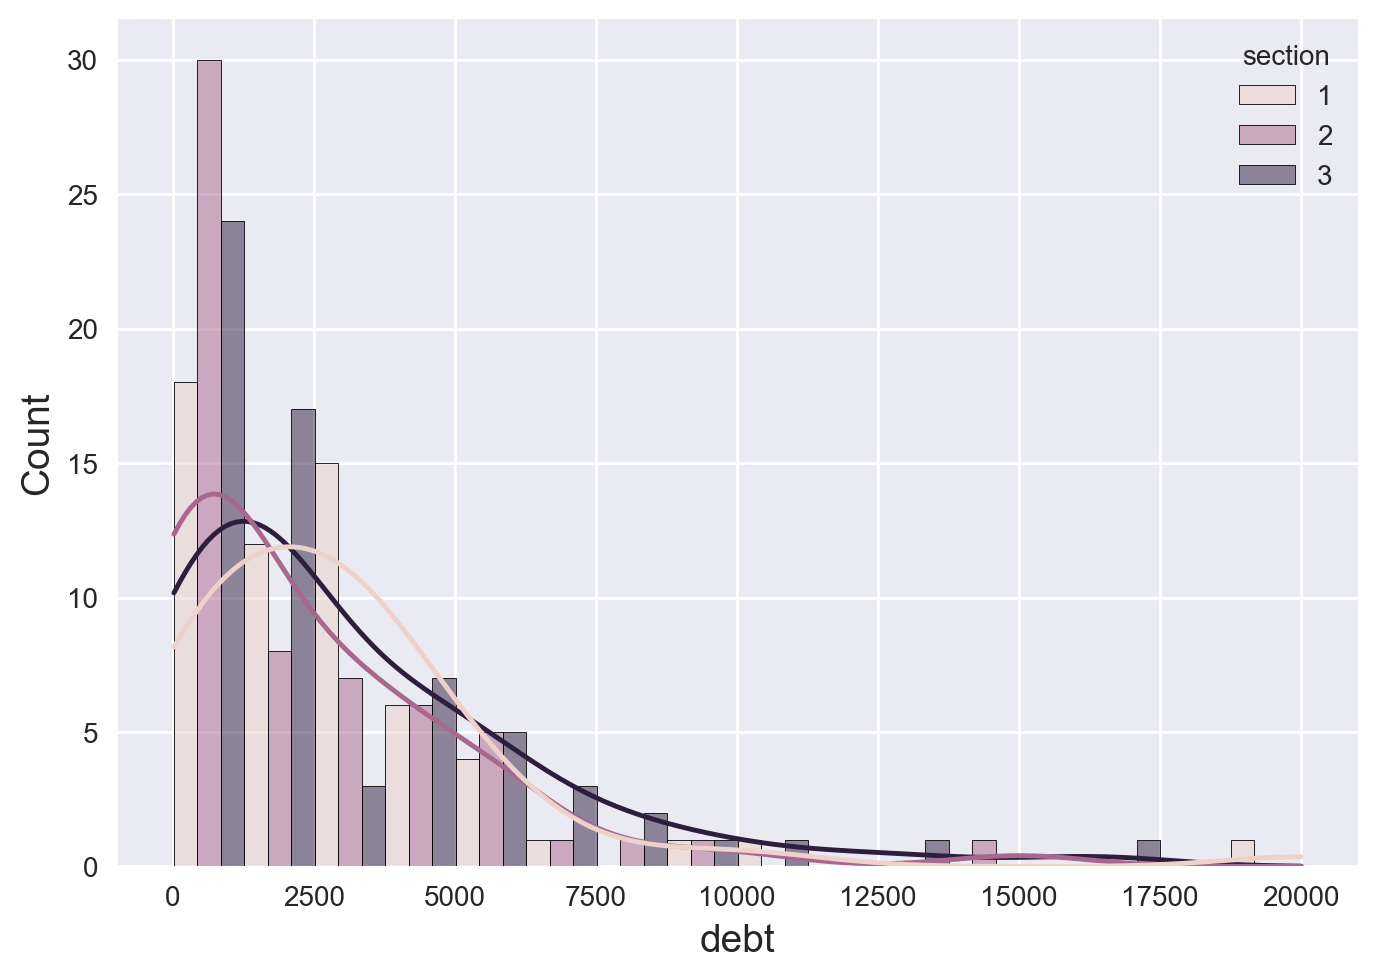

In [301]:
sns.histplot(data=debt, x="debt", hue="section", multiple="dodge", kde=True)

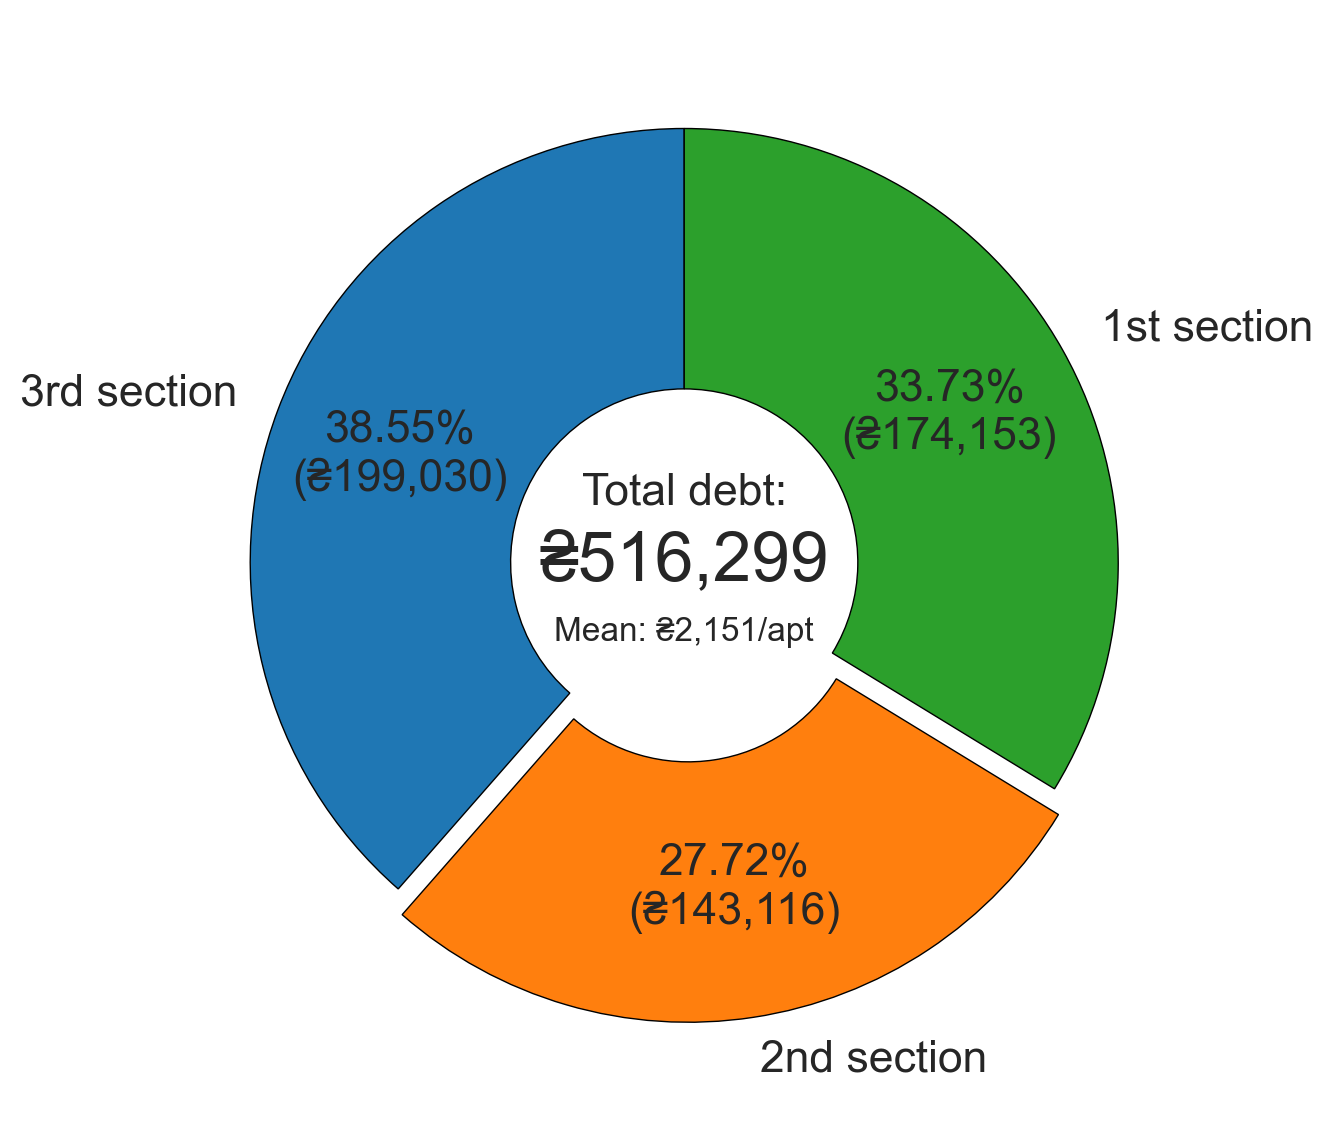

In [302]:
def to_percentage_and_value(x):
    return '{:.2f}%\n(₴{:,.0f})'.format(x, total_debt * x / 100)

ax = debt.groupby("section")["debt"].sum().sort_index(ascending=False).plot.pie(
    labels=["3rd section", "2nd section", "1st section"],
    figsize=(7, 8),
    autopct=to_percentage_and_value,
    fontsize=16,
    explode=(0, 0.06, 0),
    pctdistance=0.7,
    wedgeprops={"width": 0.6, "edgecolor": "black", "linewidth": 0.5},
    startangle=90)
ax.set_ylabel("")

plt.text(0, 0.16, "Total debt:", ha='center', va='center', fontsize=16)
plt.text(0, 0.0, f"₴{total_debt:,.0f}", ha='center', va='center', fontsize=25)
plt.text(0, -0.16, f"Mean: ₴{total_debt / total_apts:,.0f}/apt", ha='center', va='center', fontsize=12)
plt.savefig("debt_pie.png", bbox_inches="tight")

In [303]:
def create_donut_chart(fig, ax, section_num):
  debt_for_section = debt.groupby("section")["debt"].sum().iloc[section_num - 1]
  debt_in_percentage = debt_for_section / total_debt

  ax.pie(
      [1 - debt_in_percentage, debt_in_percentage],
      startangle=90,
      colors=["white", plt.cm.tab10.colors[3]])

  donut_hole = plt.Circle((0, 0), 0.66, fc="white")
  fig = plt.gcf()
  fig.gca().add_artist(donut_hole)

  plt.text(0, 1.23, f"The {section_num} section", ha="center", va="center", fontsize=25)
  plt.text(0, 0.27, f"owes", ha="center", va="center", fontsize=20)
  plt.text(0, 0, f"{debt_in_percentage * 100:,.2f}%", ha="center", va="center", fontsize=50)
  plt.text(0, -0.27, f"of all debt", ha="center", va="center", fontsize=20)
  plt.text(0, -1.23, f"which is ₴{debt_for_section:,.0f}", ha="center", va="center", fontsize=20)

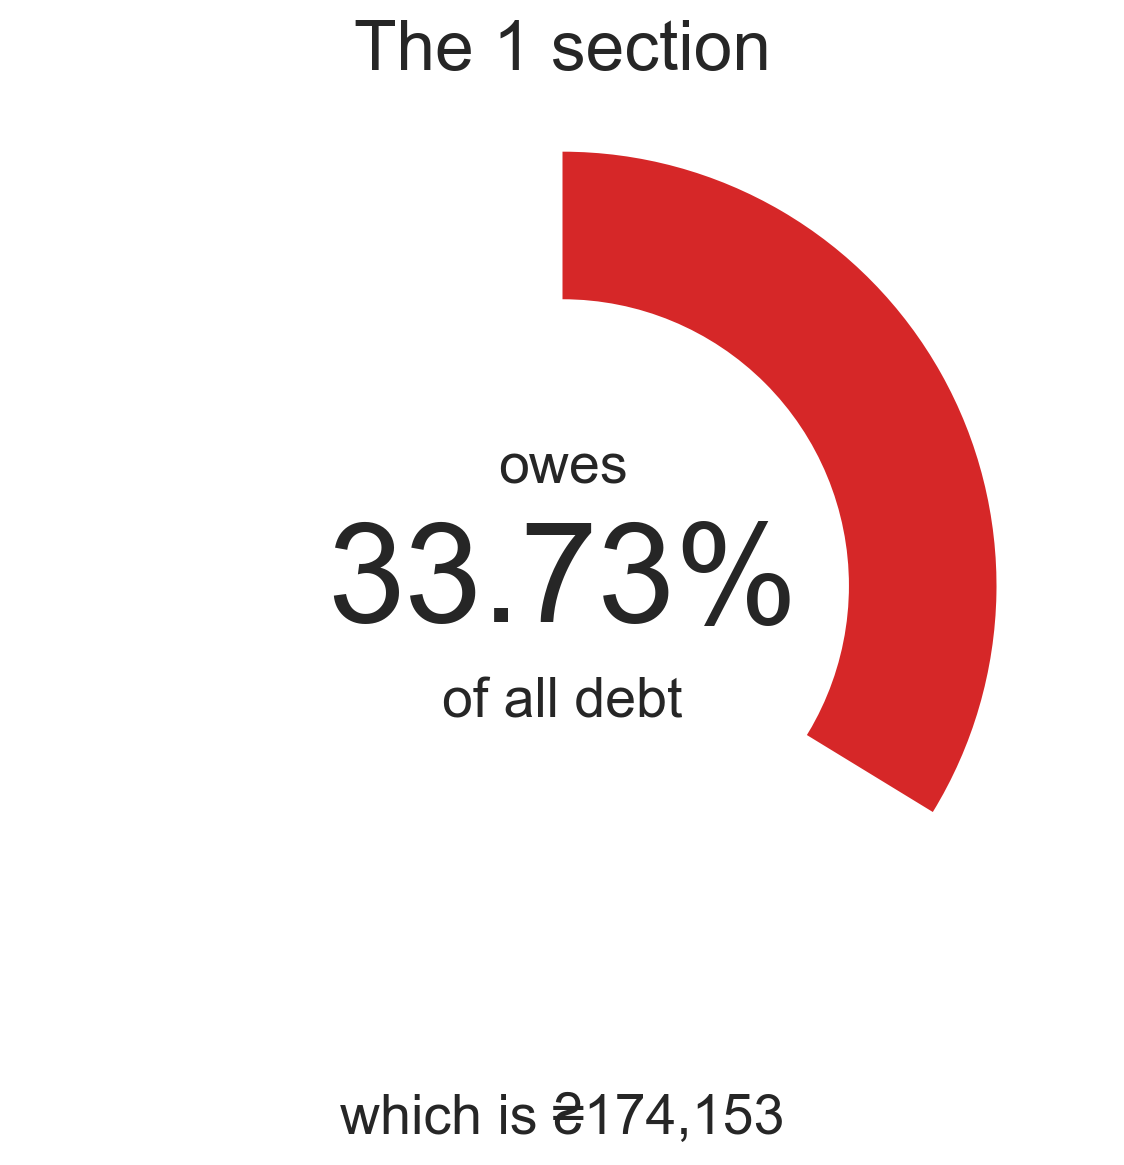

In [304]:
fig, ax = plt.subplots(figsize=(7, 8))
section_num = 1
create_donut_chart(fig, ax, section_num)
plt.savefig(f"debt_donut_{section_num}.png", bbox_inches="tight")

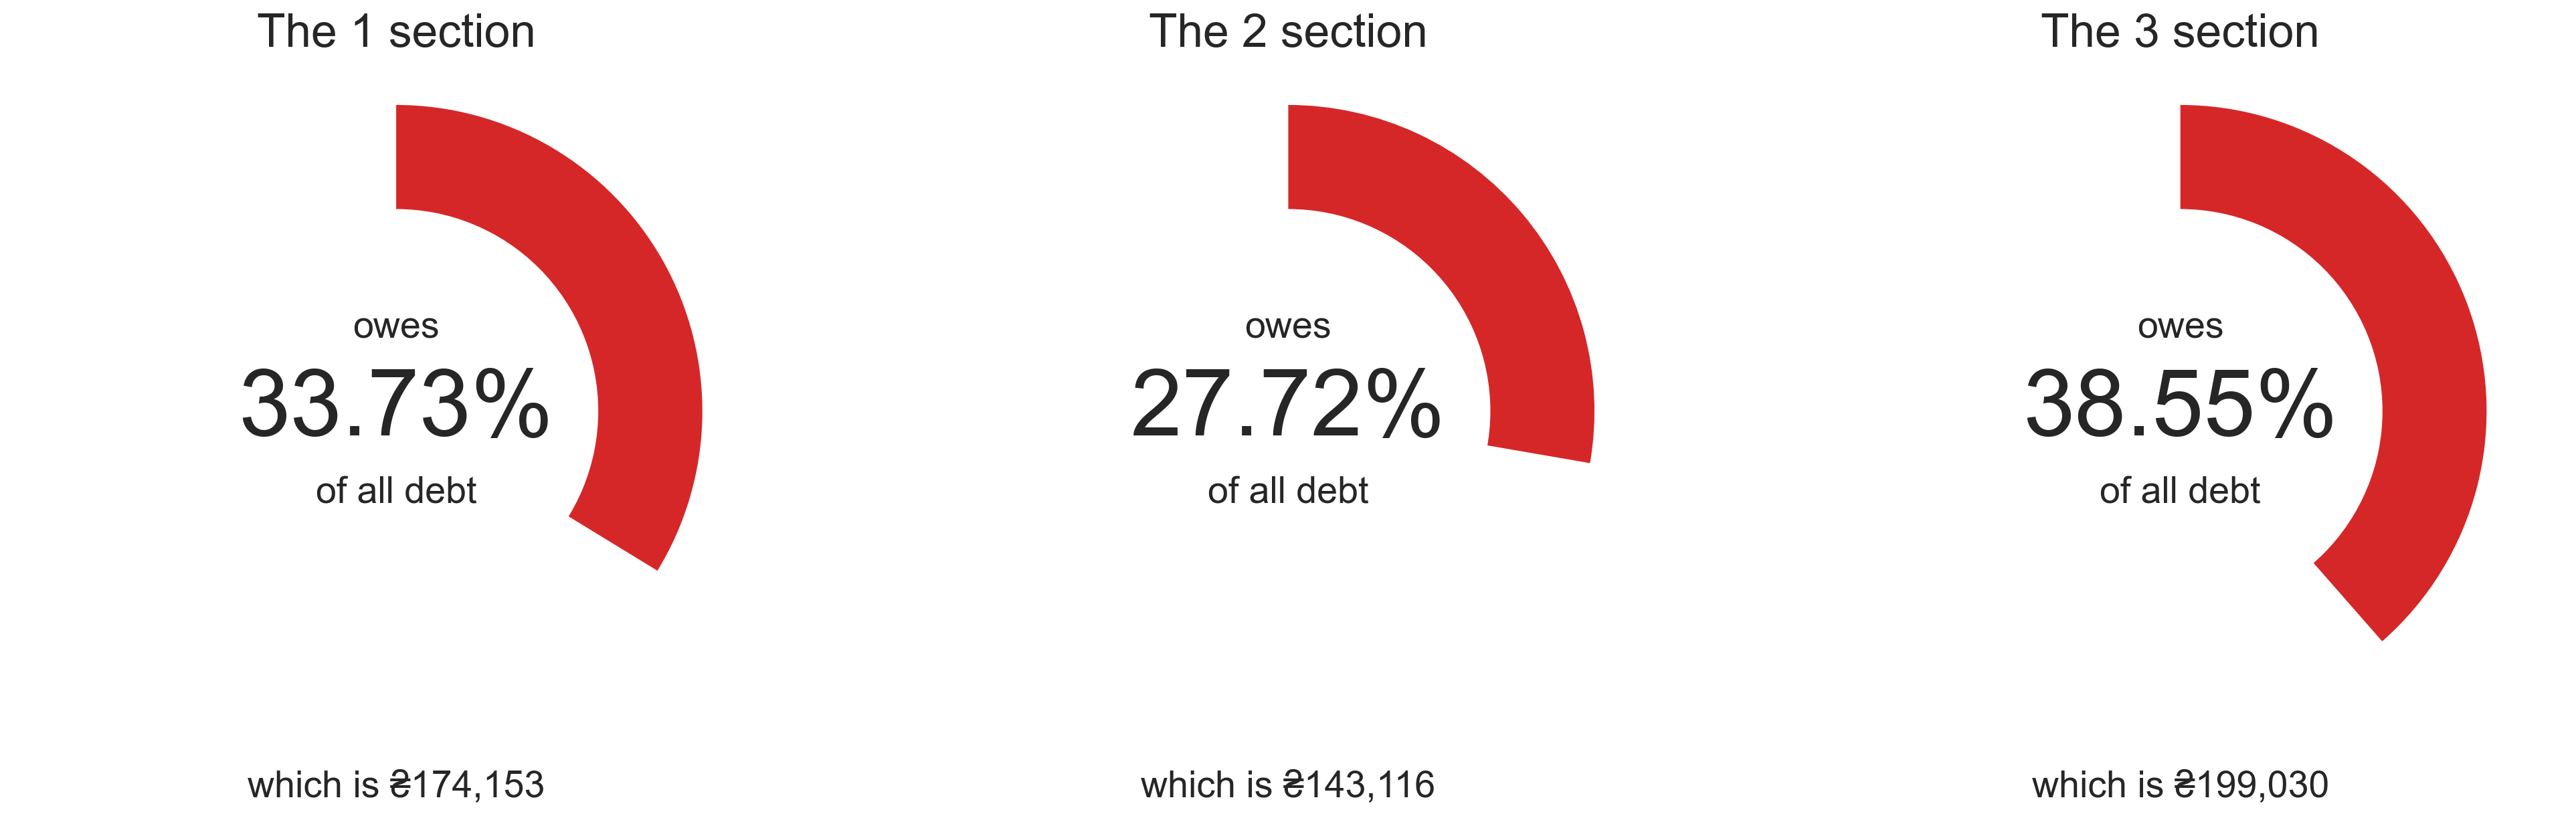

In [305]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(20, 6), constrained_layout=True)
gs = GridSpec(nrows=3, ncols=9, figure=fig)

ax1 = fig.add_subplot(gs[:, 0:3])
create_donut_chart(fig, ax1, 1)

ax2 = fig.add_subplot(gs[:, 3:6])
create_donut_chart(fig, ax2, 2)

ax3 = fig.add_subplot(gs[:, 6:9])
create_donut_chart(fig, ax3, 3)

plt.savefig("debt_donut_grid.png", bbox_inches="tight")

In [306]:
grouped_by_section = debt.groupby("section")

def get_num_of_apts_with_debt(section_num):
  return grouped_by_section.get_group(section_num).shape[0]

def get_num_of_apts_without_debt(section_num):
  return apts_per_section - get_num_of_apts_with_debt(section_num)

without_debt = []
with_debt = []
for x in range(1, sections + 1):
    without_debt.append(get_num_of_apts_without_debt(x))
    with_debt.append(get_num_of_apts_with_debt(x))

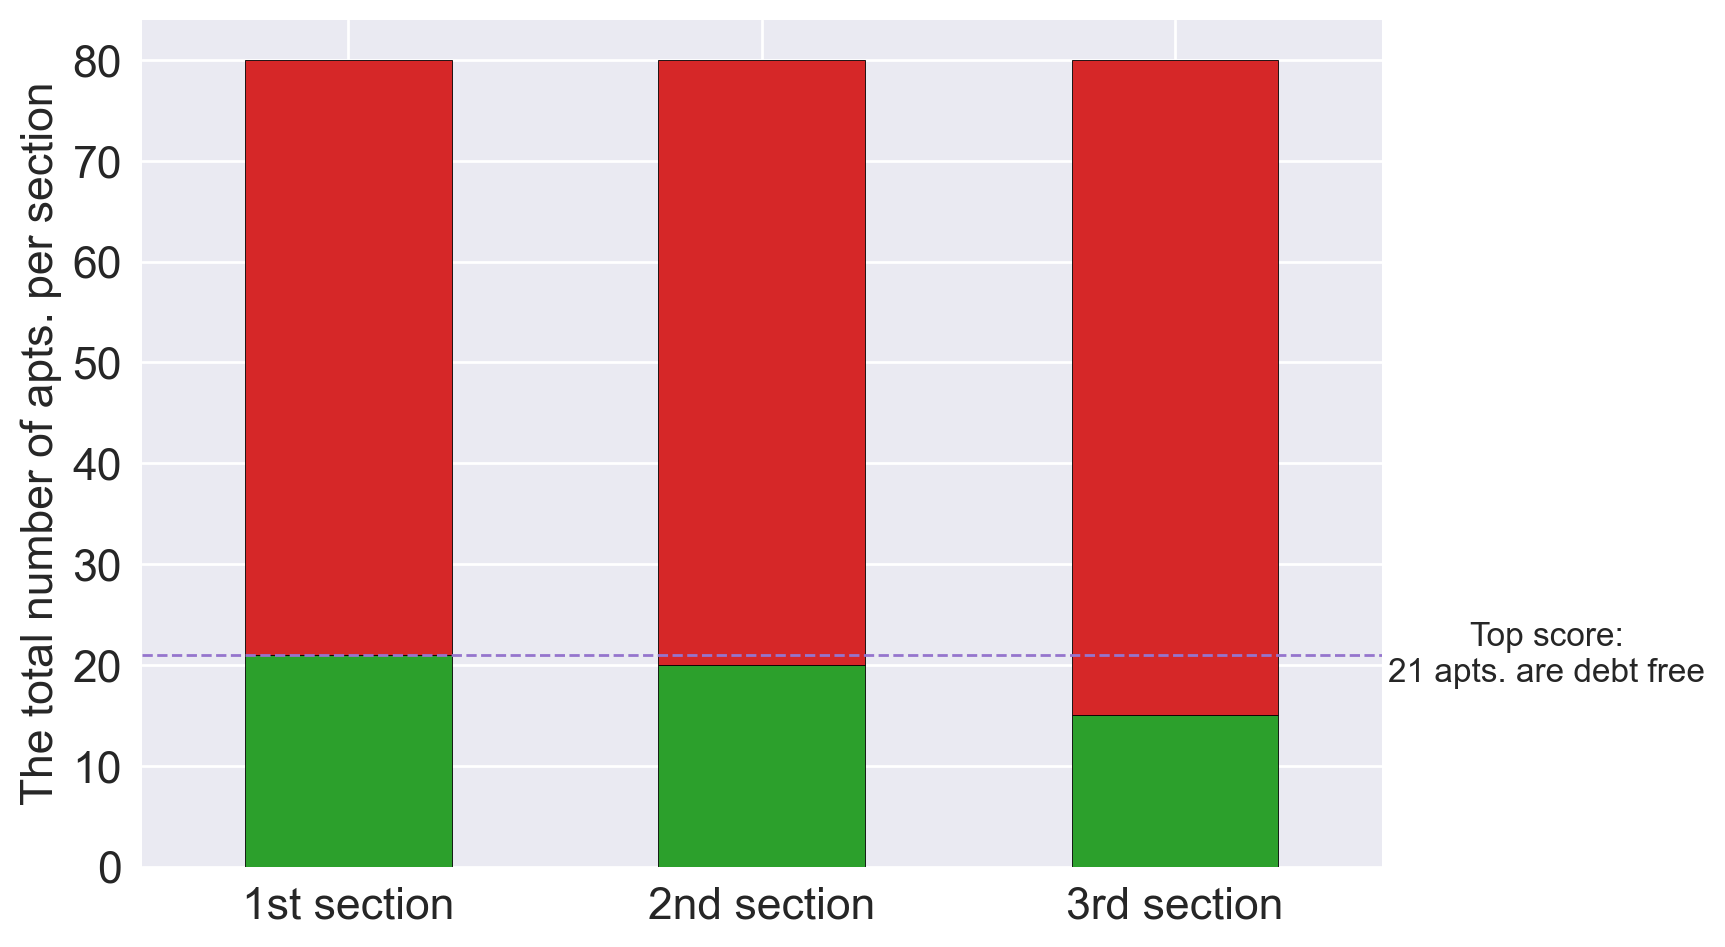

In [307]:
ax = pd.DataFrame({"without_debt" : without_debt, "with_debt": with_debt}).plot.bar(
    legend=False,
    fontsize=16,
    color=[plt.cm.tab10.colors[2], plt.cm.tab10.colors[3]],
    stacked=True,
    edgecolor="black")
ax.set_xticks([0,1,2], ["1st section", "2nd section", "3rd section"], rotation=0)
ax.set_ylabel("The total number of apts. per section", fontsize=16)
ax.axhline(max(without_debt), color="#9575cd", linestyle="--", linewidth=1)
ax.text(2.9, 21, "Top score:\n21 apts. are debt free", ha="center", va="center", fontsize=12)

plt.savefig("debt_no_bar.png", bbox_inches="tight")

[Text(0, 0, '13682'),
 Text(0, 0, '11843'),
 Text(0, 0, '34887'),
 Text(0, 0, '18361'),
 Text(0, 0, '17746'),
 Text(0, 0, '13131'),
 Text(0, 0, '6305'),
 Text(0, 0, '14894'),
 Text(0, 0, '36390'),
 Text(0, 0, '6914')]

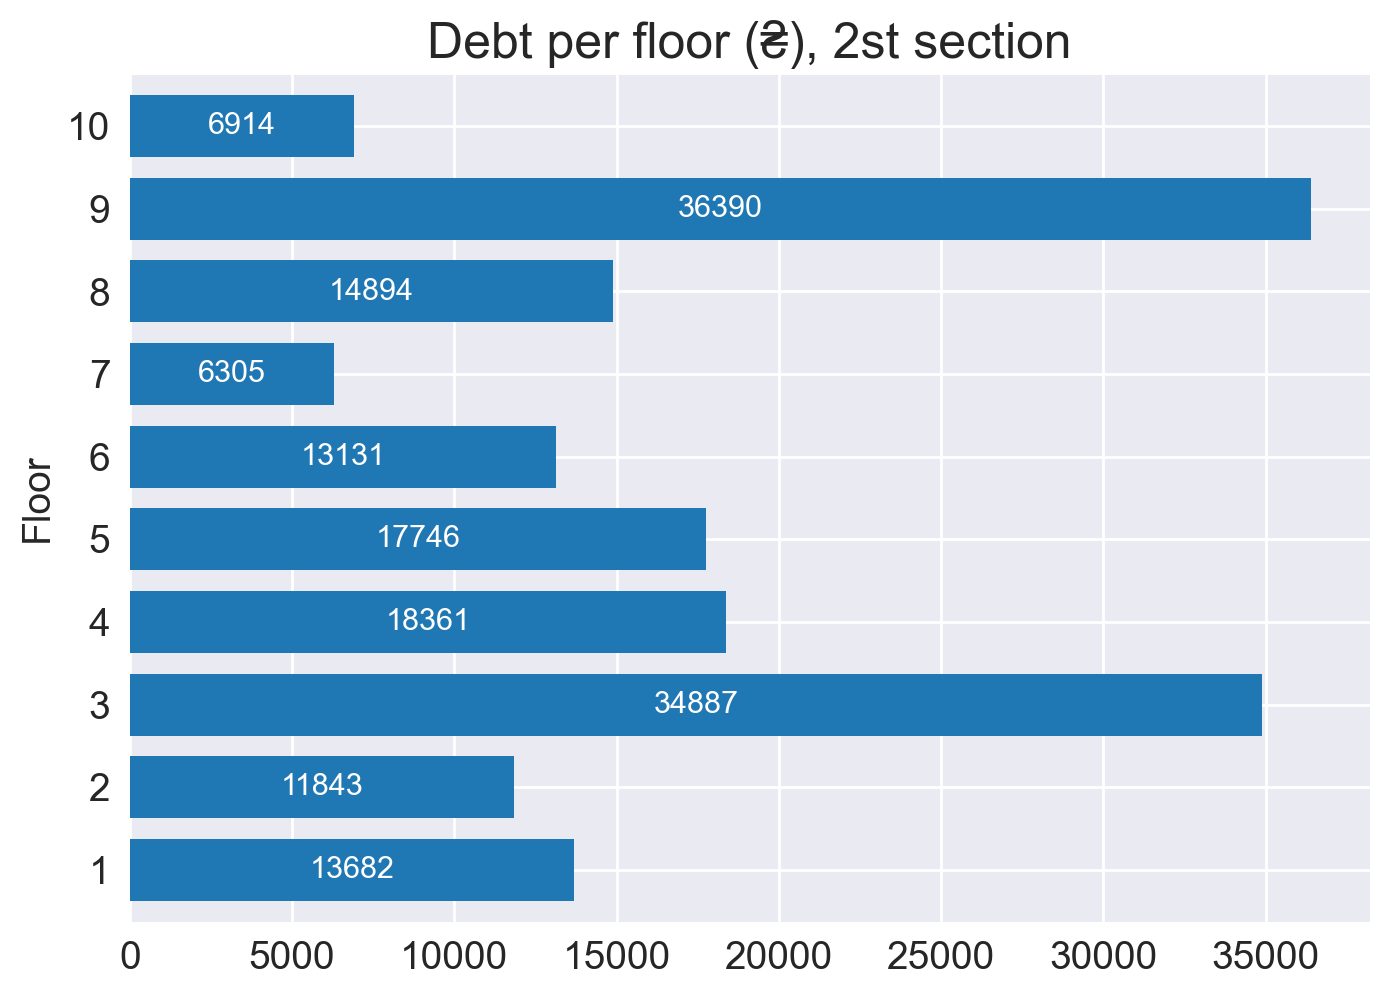

In [308]:
section_num = 1
ax = debt[debt["section"] == section_num].groupby(["floor"])["debt"].sum().plot.barh(fontsize=14, width = 0.75)
ax.set_ylabel("Floor")
ax.set_title(f"Debt per floor (₴), {section}st section", fontsize=18)
ax.bar_label(ax.containers[0], fmt="%.0f", fontsize=11, label_type="center", color="white")

[Text(0, 0, '34534'),
 Text(0, 0, '16063'),
 Text(0, 0, '4260'),
 Text(0, 0, '6840'),
 Text(0, 0, '13240'),
 Text(0, 0, '15822'),
 Text(0, 0, '26001'),
 Text(0, 0, '7474'),
 Text(0, 0, '14921'),
 Text(0, 0, '3961')]

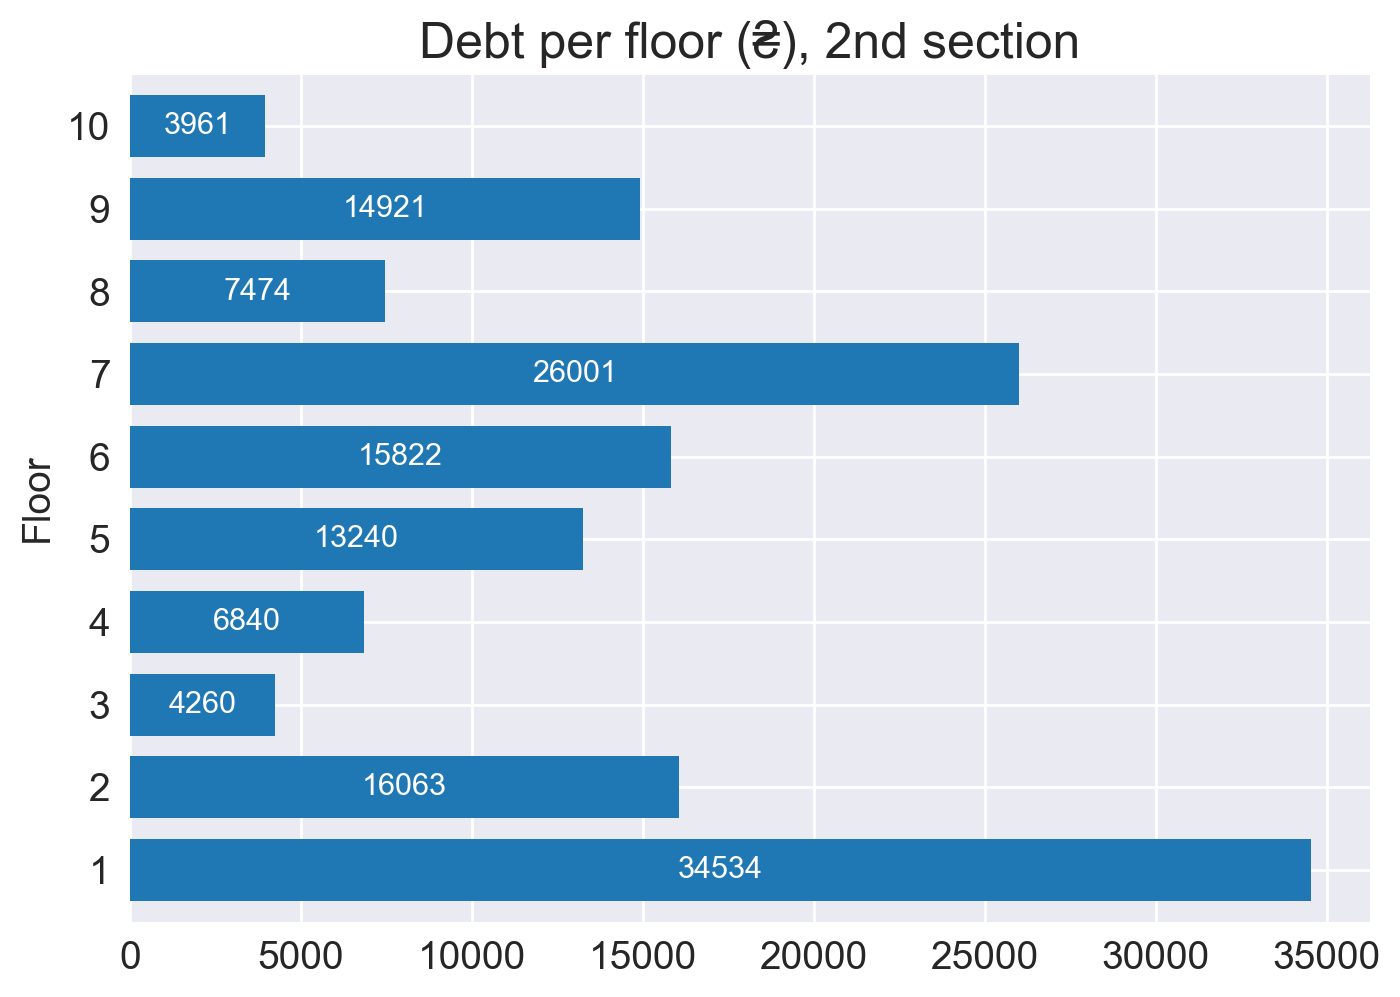

In [309]:
section_num = 2
ax = debt[debt["section"] == section_num].groupby(["floor"])["debt"].sum().plot.barh(fontsize=14, width = 0.75)
ax.set_ylabel("Floor")
ax.set_title(f"Debt per floor (₴), {section_num}nd section", fontsize=18)
ax.bar_label(ax.containers[0], fmt="%.0f", fontsize=11, label_type="center", color="white")

[Text(0, 0, '29225'),
 Text(0, 0, '31019'),
 Text(0, 0, '3659'),
 Text(0, 0, '8039'),
 Text(0, 0, '17248'),
 Text(0, 0, '15908'),
 Text(0, 0, '25980'),
 Text(0, 0, '38077'),
 Text(0, 0, '15201'),
 Text(0, 0, '14674')]

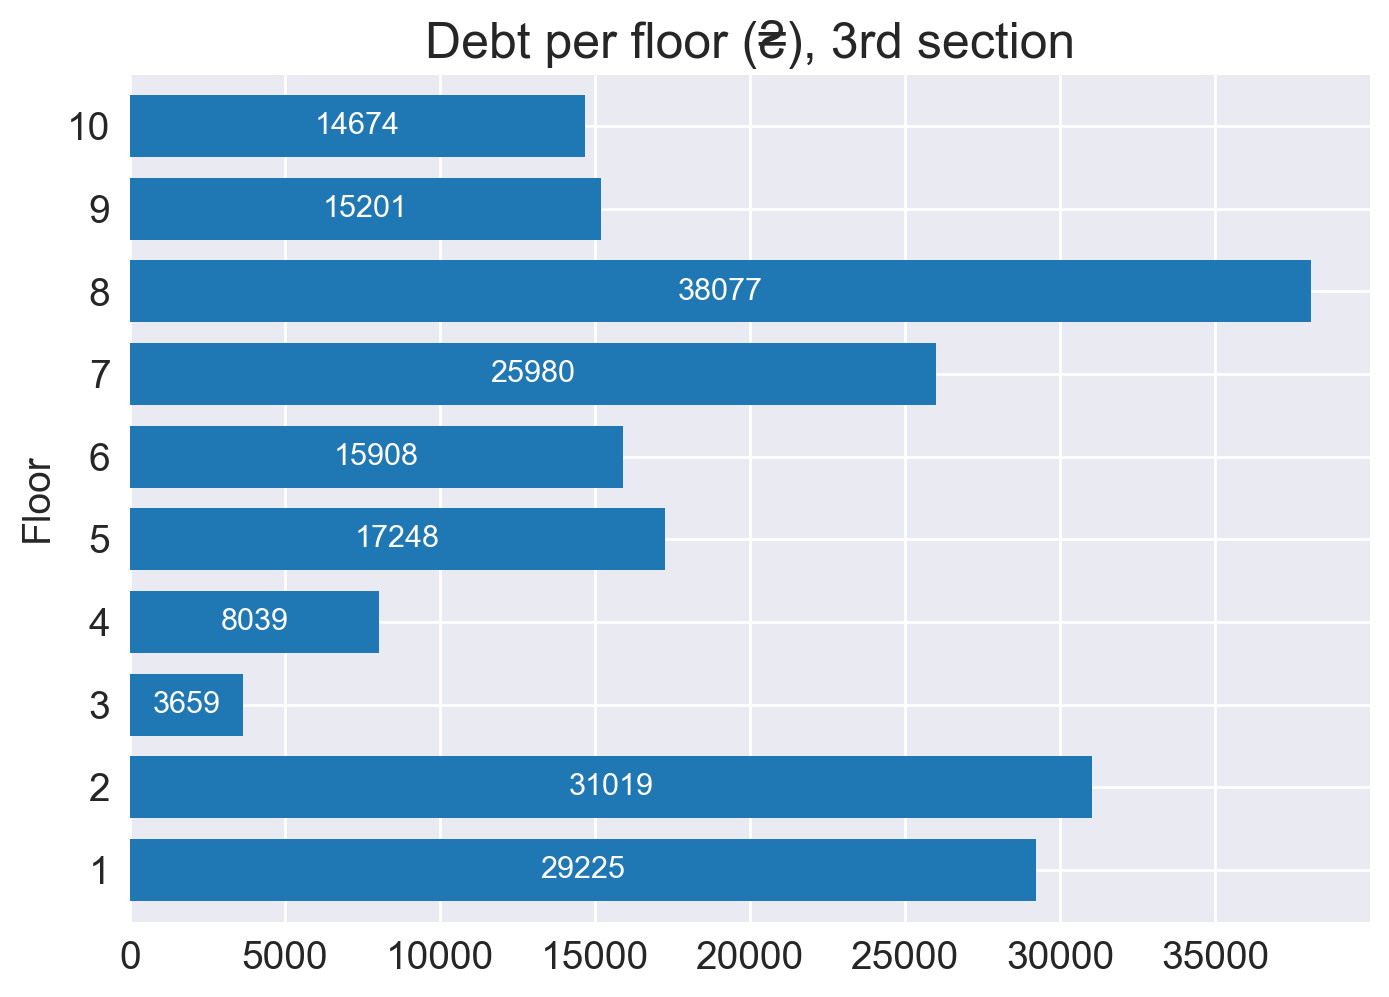

In [310]:
section_num = 3
ax = debt[debt["section"] == section_num].groupby(["floor"])["debt"].sum().plot.barh(fontsize=14, width = 0.75)
ax.set_ylabel("Floor")
ax.set_title(f"Debt per floor (₴), {section_num}rd section", fontsize=18)
ax.bar_label(ax.containers[0], fmt="%.0f", fontsize=11, label_type="center", color="white")

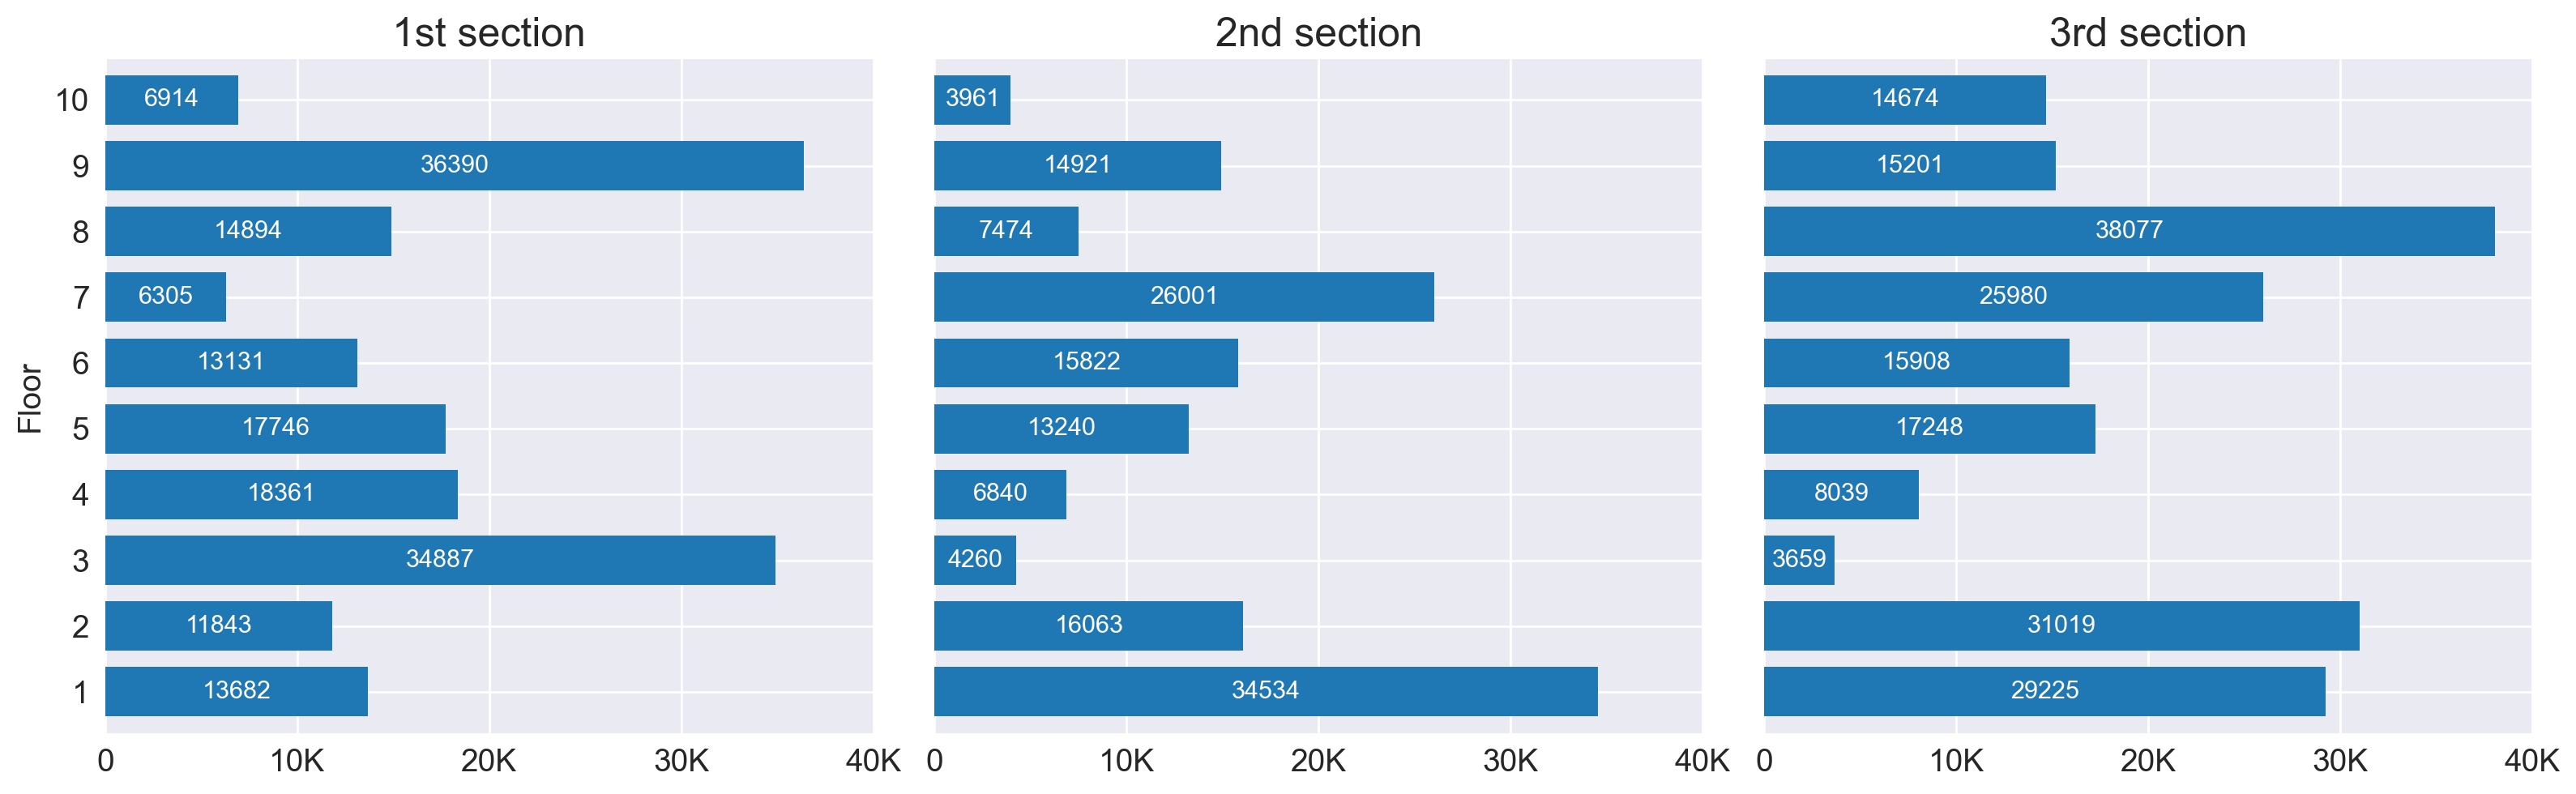

In [311]:
fix, axs = plt.subplots(1, 3, figsize=(16, 5), sharey=True, sharex=True)

section_num = 1
ax = debt[debt["section"] == section_num].groupby(["floor"])["debt"].sum().plot.barh(fontsize=14, width = 0.75, ax=axs[0])
ax.set_ylabel("Floor")
ax.set_title(f"{section_num}st section", fontsize=18)
ax.bar_label(ax.containers[0], fmt="%.0f", fontsize=11, label_type="center", color="white")

section_num = 2
ax = debt[debt["section"] == section_num].groupby(["floor"])["debt"].sum().plot.barh(fontsize=14, width = 0.75, ax=axs[1])
ax.set_ylabel("")
ax.set_title(f"{section_num}nd section", fontsize=18)
ax.bar_label(ax.containers[0], fmt="%.0f", fontsize=11, label_type="center", color="white")

section_num = 3
ax = debt[debt["section"] == section_num].groupby(["floor"])["debt"].sum().plot.barh(fontsize=14, width = 0.75, ax=axs[2])
ax.set_ylabel("")
ax.set_title(f"{section_num}rd section", fontsize=18)
ax.bar_label(ax.containers[0], fmt="%.0f", fontsize=11, label_type="center", color="white")

for ax in axs:
    ax.set_xticks([0, 10000, 20000, 30000, 40000])
    ax.set_xticklabels(["0", "10K", "20K", "30K", "40K"])

plt.tight_layout()

Text(19156.829999999998, 9.1, 'Mean: ₴17,415/floor')

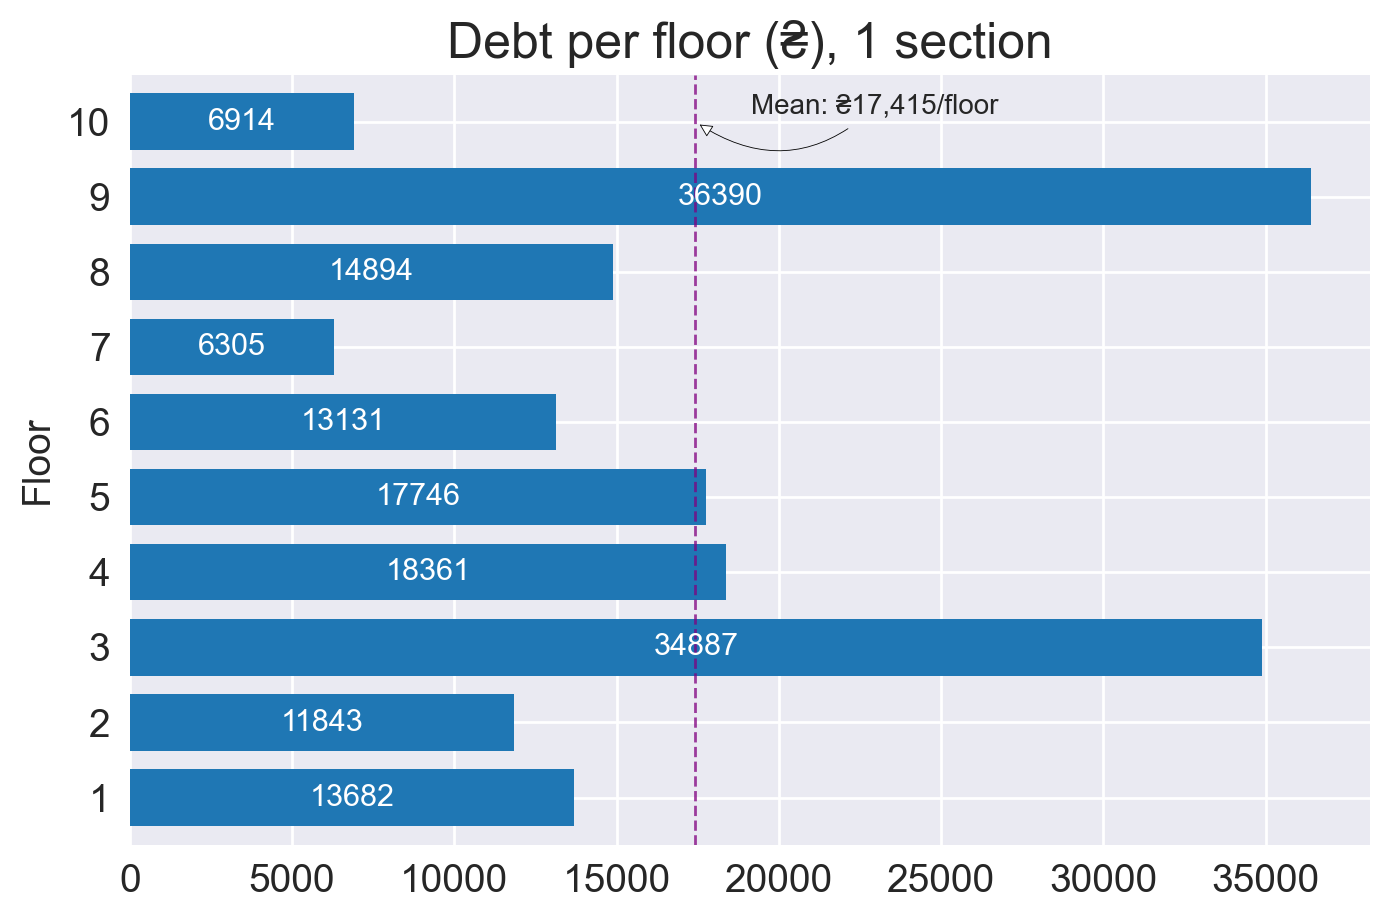

In [312]:
section_num = 1
ax = debt[debt["section"] == section_num].groupby(["floor"])["debt"].sum().plot.barh(figsize=(8, 5), fontsize=14, width = 0.75)
ax.set_ylabel("Floor")
ax.set_title(f"Debt per floor (₴), {section_num} section", fontsize=18)
ax.bar_label(ax.containers[0], fmt="%.0f", fontsize=11, label_type="center", color="white")

ax.axvline(debt[debt["section"] == section_num].groupby(["floor"]).sum()["debt"].mean(), color="purple", linestyle="--", linewidth=1, alpha=0.75)

mean = debt[debt["section"] == section_num].groupby(["floor"]).sum()["debt"].mean()
ax.annotate('Mean: ₴{:,.0f}/floor'.format(mean), xy=(mean, 9), xytext=(mean + mean * 0.1, 9.1), size=10, arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.4", fc="w"))

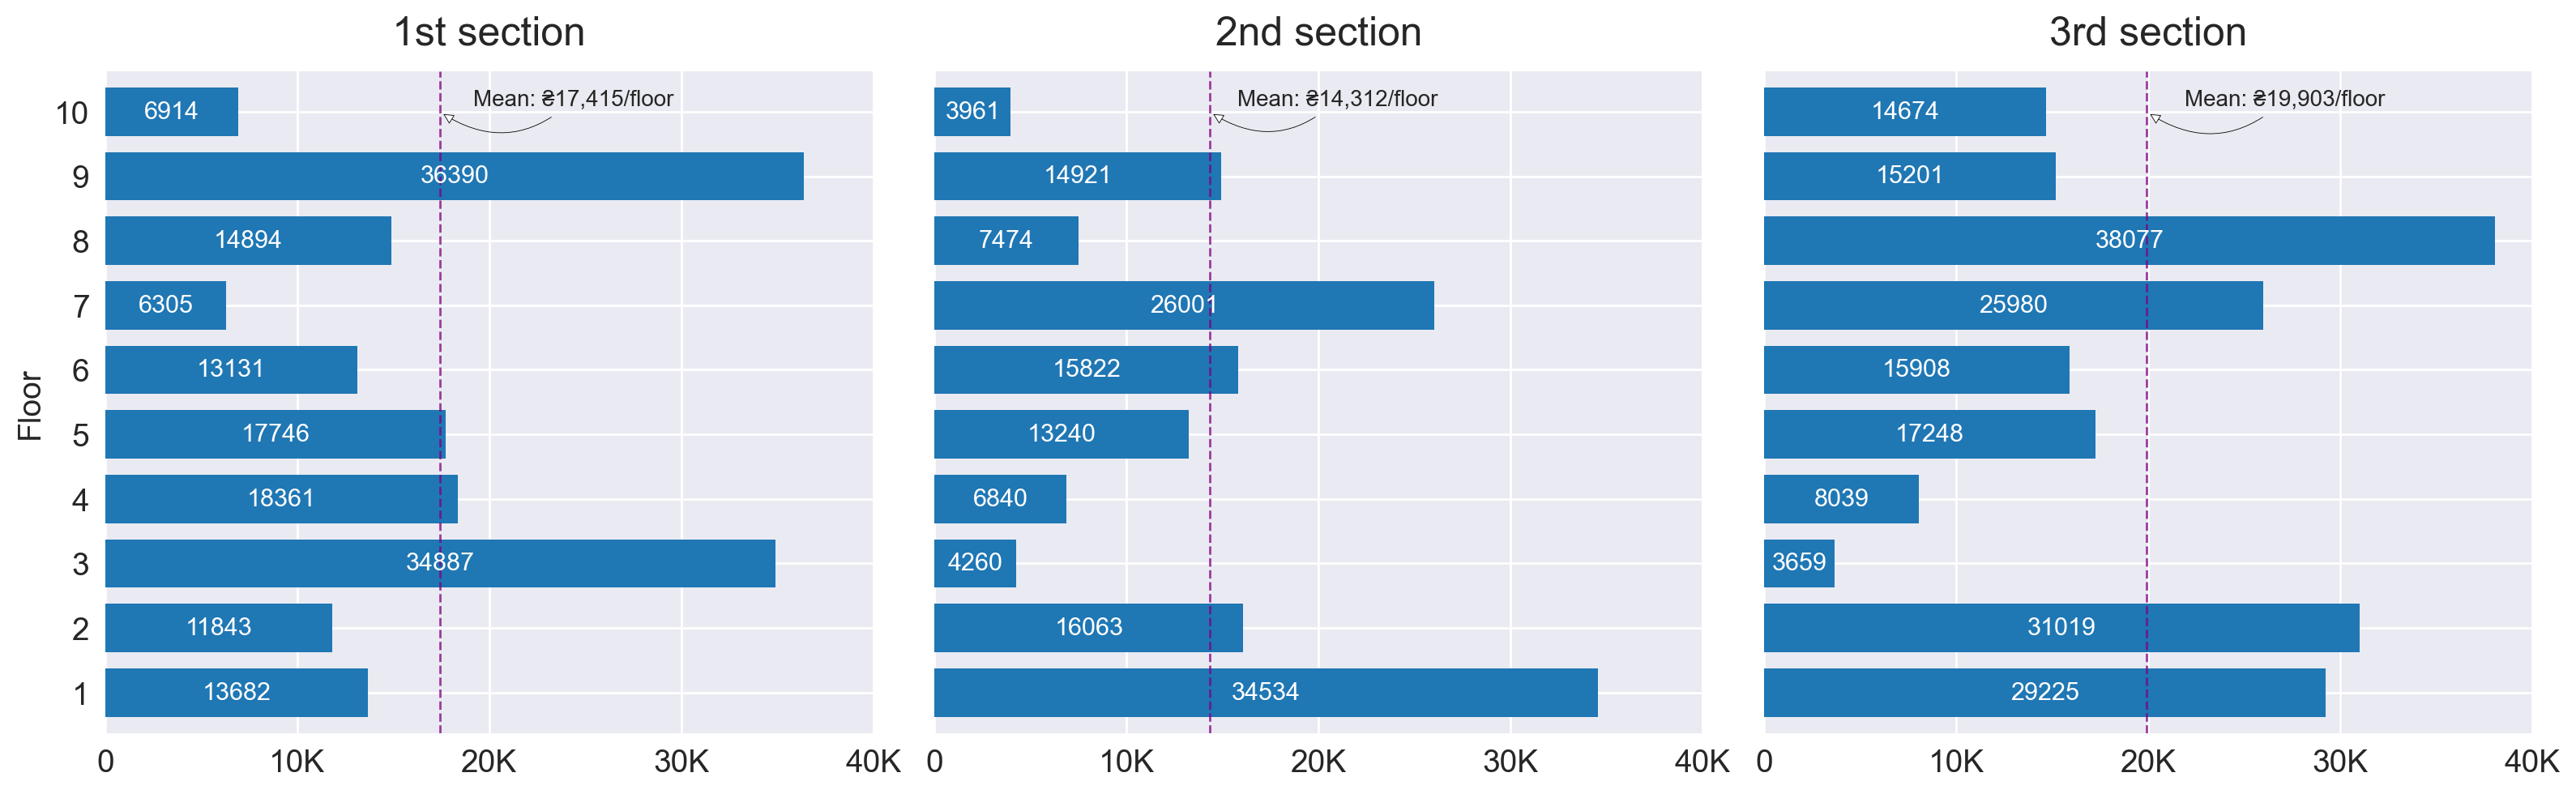

In [313]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharey=True, sharex=True)

section_num = 1
ax = debt[debt["section"] == section_num].groupby(["floor"])["debt"].sum().plot.barh(fontsize=14, width = 0.75, ax=axs[0])
ax.set_ylabel("Floor")
ax.set_title(f"{section_num}st section", fontsize=18, y=1.02)
ax.bar_label(ax.containers[0], fmt="%.0f", fontsize=11, label_type="center", color="white")

mean = debt[debt["section"] == section_num].groupby(["floor"]).sum()["debt"].mean()
ax.axvline(mean, color="purple", linestyle="--", linewidth=1, alpha=0.75)
ax.annotate('Mean: ₴{:,.0f}/floor'.format(mean), xy=(mean, 9), xytext=(mean + mean * 0.1, 9.1), size=10, arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.4", fc="w"))

section_num = 2
ax = debt[debt["section"] == section_num].groupby(["floor"])["debt"].sum().plot.barh(fontsize=14, width = 0.75, ax=axs[1])
ax.set_ylabel("")
ax.set_title(f"{section_num}nd section", fontsize=18, y=1.02)
ax.bar_label(ax.containers[0], fmt="%.0f", fontsize=11, label_type="center", color="white")

mean = debt[debt["section"] == section_num].groupby(["floor"]).sum()["debt"].mean()
ax.axvline(mean, color="purple", linestyle="--", linewidth=1, alpha=0.75)
ax.annotate('Mean: ₴{:,.0f}/floor'.format(mean), xy=(mean, 9), xytext=(mean + mean * 0.1, 9.1), size=10, arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.4", fc="w"))

section_num = 3
ax = debt[debt["section"] == section_num].groupby(["floor"])["debt"].sum().plot.barh(fontsize=14, width = 0.75, ax=axs[2])
ax.set_ylabel("")
ax.set_title(f"{section_num}rd section", fontsize=18, y=1.02)
ax.bar_label(ax.containers[0], fmt="%.0f", fontsize=11, label_type="center", color="white")

mean = debt[debt["section"] == section_num].groupby(["floor"]).sum()["debt"].mean()
ax.axvline(mean, color="purple", linestyle="--", linewidth=1, alpha=0.75)
ax.annotate('Mean: ₴{:,.0f}/floor'.format(mean), xy=(mean, 9), xytext=(mean + mean * 0.1, 9.1), size=10, arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.4", fc="w"))

for ax in axs:
    ax.set_xticks([0, 10000, 20000, 30000, 40000])
    ax.set_xticklabels(["0", "10K", "20K", "30K", "40K"])

plt.tight_layout()

Text(0, 10, 'Mean: ₴2,952/apt')

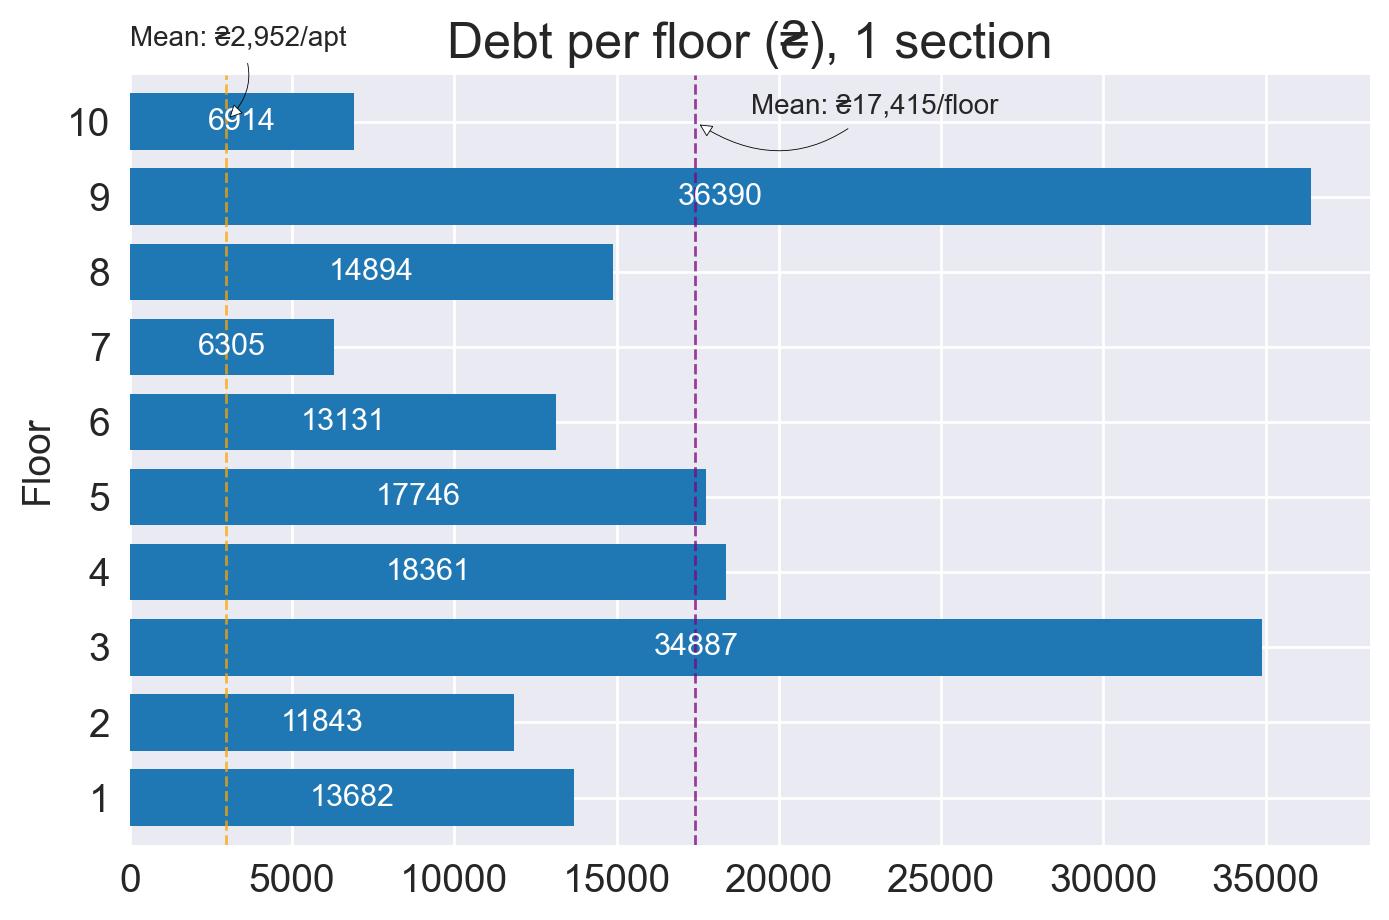

In [314]:
section_num = 1
ax = debt[debt["section"] == section_num].groupby(["floor"])["debt"].sum().plot.barh(figsize=(8, 5), fontsize=14, width = 0.75)
ax.set_ylabel("Floor")
ax.set_title(f"Debt per floor (₴), {section_num} section", fontsize=18)
ax.bar_label(ax.containers[0], fmt="%.0f", fontsize=11, label_type="center", color="white")

mean_per_floor = debt[debt["section"] == section_num].groupby(["floor"]).sum()["debt"].mean()
ax.axvline(mean_per_floor, color="purple", linestyle="--", linewidth=1, alpha=0.75)
ax.annotate(
    "Mean: ₴{:,.0f}/floor".format(mean_per_floor),
    xy=(mean_per_floor, 9),
    xytext=(mean_per_floor + mean_per_floor * 0.1, 9.1),
    size=10,
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.4", fc="w"))

mean_per_apt = debt[debt["section"] == section_num]["debt"].mean()
ax.axvline(mean_per_apt, color="orange", linestyle="--", linewidth=1, alpha=0.75)
ax.annotate(
    "Mean: ₴{:,.0f}/apt".format(mean_per_apt),
    xy=(mean_per_apt, 9),
    xytext=(0, 10),
    size=10,
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.4", fc="w"))

In [315]:
def draw_mean_line_per_apt(ax, section_num):
    mean = debt[debt["section"] == section_num]["debt"].mean()
    ax.axvline(mean, color="#ffd54f", linestyle="--", linewidth=1, alpha=0.8)
    ax.annotate("Mean: ₴{:,.0f}/apt".format(mean),
                xy=(mean, 9.5), xytext=(mean, 10), size=10, alpha=0.5,
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.3"))

In [316]:
def draw_mean_line_per_floor(ax, section_num):
    mean = debt[debt["section"] == section_num].groupby(["floor"]).sum()["debt"].mean()
    ax.axvline(mean, color="#9575cd", linestyle="--", linewidth=1, alpha=0.8)
    ax.annotate("Mean: ₴{:,.0f}/floor".format(mean),
                xy=(mean, 9), xytext=(mean + mean * 0.05, 9.1), size=10, alpha=0.5,
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.4"))

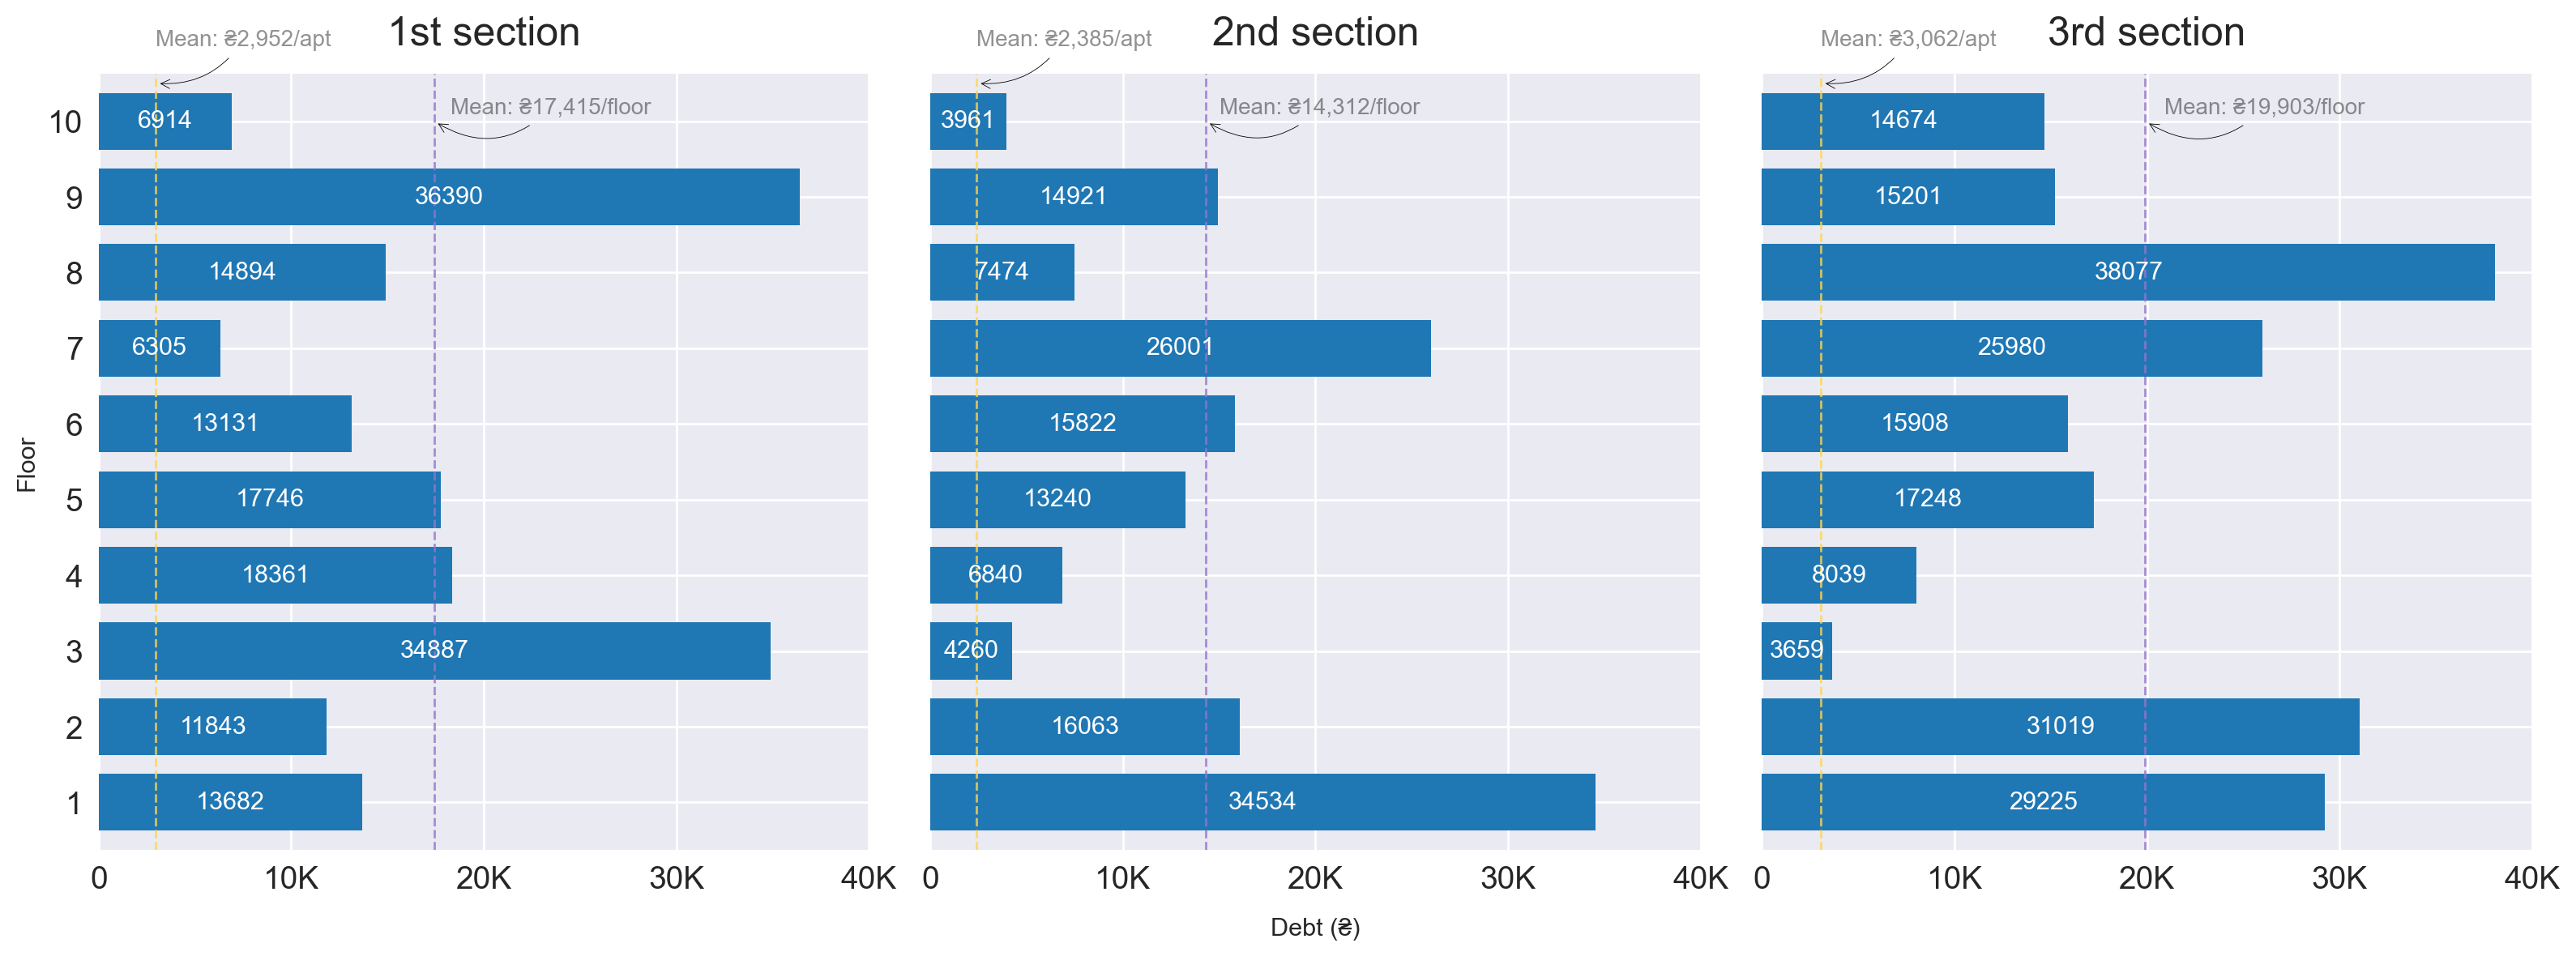

In [317]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6), sharey=True, sharex=True)

section_num = 1
ax = debt[debt["section"] == section_num].groupby(["floor"])["debt"].sum().plot.barh(fontsize=14, width = 0.75, ax=axs[0])
ax.set_ylabel("Floor", fontsize=11)
ax.set_title(f"{section_num}st section", fontsize=18, y=1.02)
ax.bar_label(ax.containers[0], fmt="%.0f", fontsize=11, label_type="center", color="white")

draw_mean_line_per_floor(ax, section_num)
draw_mean_line_per_apt(ax, section_num)

section_num = 2
ax = debt[debt["section"] == section_num].groupby(["floor"])["debt"].sum().plot.barh(fontsize=14, width = 0.75, ax=axs[1])
ax.set_ylabel("")
ax.set_xlabel("Debt (₴)", fontsize=11, labelpad=10)
ax.set_title(f"{section_num}nd section", fontsize=18, y=1.02)
ax.bar_label(ax.containers[0], fmt="%.0f", fontsize=11, label_type="center", color="white")

draw_mean_line_per_floor(ax, section_num)
draw_mean_line_per_apt(ax, section_num)

section_num = 3
ax = debt[debt["section"] == section_num].groupby(["floor"])["debt"].sum().plot.barh(fontsize=14, width = 0.75, ax=axs[2])
ax.set_ylabel("")
ax.set_title(f"{section_num}rd section", fontsize=18, y=1.02)
ax.bar_label(ax.containers[0], fmt="%.0f", fontsize=11, label_type="center", color="white")

draw_mean_line_per_floor(ax, section_num)
draw_mean_line_per_apt(ax, section_num)

for ax in axs:
    ax.set_xticks([0, 10000, 20000, 30000, 40000])
    ax.set_xticklabels(["0", "10K", "20K", "30K", "40K"], fontsize=14)

plt.tight_layout()
plt.savefig("debt_per_floor.png", bbox_inches="tight")
#fig.suptitle("Total debt per floor (₴)", fontsize=24, y=1.05)

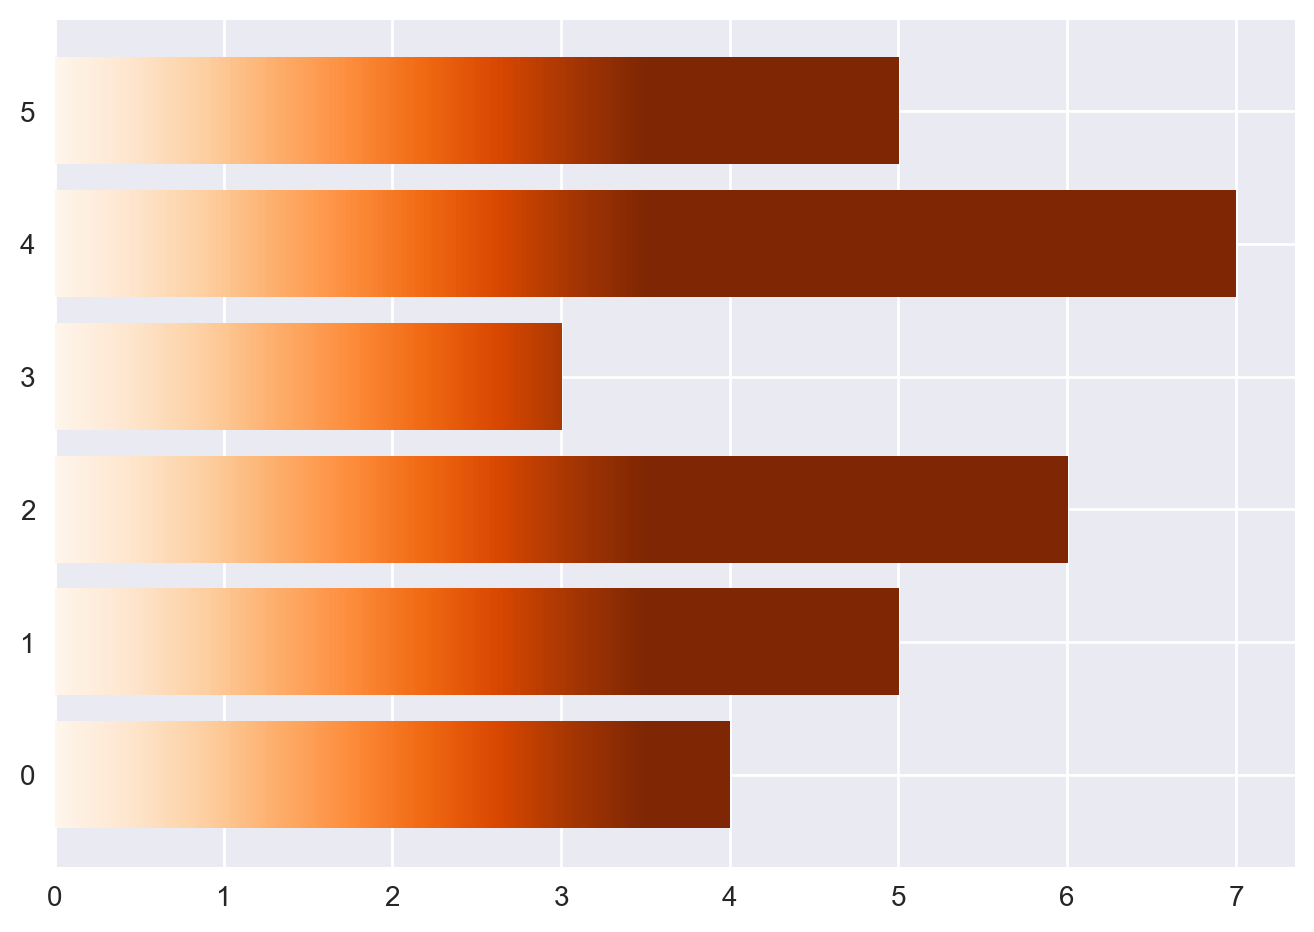

In [318]:
from matplotlib import cm

fig, ax = plt.subplots()

data=[4,5,6,3,7,5]

bar = ax.barh(range(len(data)), data)

def gradientbars(bars, cmap, stop_val):
  ax = bars[0].axes
  ax.axis(ax.get_xlim() + ax.get_ylim()) 
  for bar in bars:
    bar.set_facecolor("none")
    x, y = bar.get_xy()
    w, h = bar.get_width(), bar.get_height()
    grad = np.atleast_2d(np.linspace(0,1 * w / stop_val, 256))
    ax.imshow(grad, extent=[x, x+w, y, y+h], origin='lower', aspect="auto", zorder=1, norm=cm.colors.NoNorm(vmin=0, vmax=1), cmap=plt.get_cmap(cmap)) 
  
gradientbars(bar, "Oranges", max(data) * 0.5)